In [120]:
%matplotlib inline 

import os
from os.path import join, dirname, basename, splitext, exists
import json
import glob
import math

import pandas as pd
from rasterio.windows import Window
from rasterio.plot import show
import rasterio
from rasterio.profiles import DefaultGTiffProfile
import rasterio.features
from rasterio.windows import Window
import matplotlib.pyplot as plt
import xmltodict
import numpy as np
import shapely
from shapely.geometry import mapping, shape, box, Polygon, MultiPolygon
import shapely.ops
from shapely.affinity import translate

In [92]:
data_dir = '/opt/data/alimentiv-histo/eos'
image_dir = join(data_dir, 'EOE_Images')
label_dir = join(data_dir, 'Layer Data EOE_Images')
output_dir = join(data_dir, 'output')
new_image_dir = join(output_dir, 'images')
new_label_dir = join(output_dir, 'labels')
new_aoi_dir = join(output_dir, 'aois')
new_qgis_aoi_dir = join(output_dir, 'qgis-aois')
rv_output_dir = join(data_dir, 'rv-output')

image_paths = glob.glob(join(image_dir, '*'))
image_fns = [splitext(basename(x))[0] for x in image_paths]
label_paths = [join(label_dir, f'{x}.tif') for x in image_fns]
fov_paths = [join(label_dir, f'{x}.xml') for x in image_fns]

In [106]:
def vectorize(raster_path):
    with rasterio.open(raster_path) as src:
        arr = src.read(1)
    mask = arr == 1
    return [shape(x[0]) for x in rasterio.features.shapes(arr, mask)]

def get_bounding_box(geom):
    return box(*geom.bounds)

def get_window(geom, buffer, img_width, img_height):
    return shapely.ops.clip_by_rect(
        get_bounding_box(get_bounding_box(geom).buffer(30)), 
        0, 0, img_width, img_height)

def box_to_window(b):
    minx, miny, maxx, maxy = b.bounds
    return Window(minx, miny, maxx-minx, maxy-miny)

def to_window_coords(geom, window):
    minx, miny, maxx, maxy = window.bounds
    return shapely.ops.clip_by_rect(
        translate(geom, -minx, -miny), 
        0, 0, maxx-minx, maxy-miny)

def plot_geom(geom, ax):
    x,y = geom.exterior.xy
    ax.plot(x, y)        

def plot_slide(labels, preds, max_plots=10):
    plot_sz = min(len(labels), max_plots)
    nrows = int(round(math.sqrt(plot_sz)))
    fig, ax = plt.subplots(nrows, nrows)
    
    for label_ind, label in enumerate(labels):
        _ax = ax.flatten()[label_ind]
        if label_ind >= max_plots:
            break
        
        window = get_window(label, 30, img_width, img_height)
        geoms = MultiPolygon([window, label])

        with rasterio.open(image_path) as src:
            img_arr = src.read(window=box_to_window(window))

        _ax.imshow(img_arr.transpose([1, 2, 0]))

        window_label = to_window_coords(label, window)
        plot_geom(window_label, _ax)

        for p in preds:
            if p.intersects(window):
                plot_geom(to_window_coords(p, window), _ax)

    for _ax in ax.flatten():
        _ax.axis('off')


In [112]:
label_paths = glob.glob(join(new_label_dir, '*.tif'))
id2count = {}
for label_path in label_paths:
    labels = vectorize(label_path)
    file_id = splitext(basename(label_path))[0]
    count = len(labels)
    id2count[file_id] = count
counts = np.array(list(id2count.values()))

/srv/conda/envs/notebook/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [113]:

all_ids = list(id2count)
val_ids = [basename(x) for x in glob.glob(join(rv_output_dir, '2-17-2021a', 'predict', '*'))]
train_ids = list(set(all_ids) - set(val_ids))

In [117]:
def get_label_count(ids):
    return np.array([id2count[x] for x in ids]).sum()

print(f'train count: {get_label_count(train_ids)}')
print(f'val count: {get_label_count(val_ids)}')

plt.hist(counts)

train count: 3562
val count: 617


In [129]:
val_counts = [id2count[x] for x in val_ids]
val_df = pd.DataFrame(data={'id': val_ids, 'count': val_counts})
val_df = val_df.sort_values('count', ascending=False)
sorted_val_ids = val_df['id'].tolist()

['31', '38', '27', '9', '45', '12022', '11', '4', '33', '12030', '22042', '1']

/srv/conda/envs/notebook/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


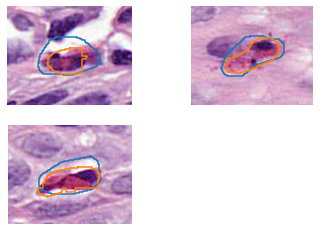

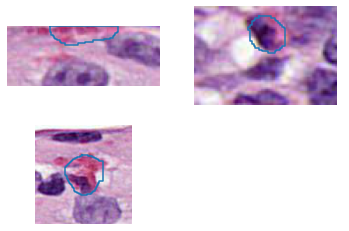

In [107]:
image_path = join(new_image_dir, '11.tif')
label_path = join(new_label_dir, '11.tif')
pred_path = join(rv_output_dir, '2-17-2021a', 'predict', '11', 'labels.tif')

with rasterio.open(image_path) as src:
    img_height, img_width = src.height, src.width

labels = vectorize(label_path)
preds = vectorize(pred_path)
max_plots = 3

plot_slide(labels, preds, max_plots=max_plots)
plot_slide(preds, labels, max_plots=max_plots)

# sort slides by label count
# confusion matrix
# filter by aoi